In [1]:
import numpy as np
import pandas as pd 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,linear
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

DATA INITILAZING AND CLEANING

In [2]:

#df = pd.ExcelFile('C:/Users/halil/Desktop/soalr_data.xlsx').parse('sheet 1')
weather_raw = pd.read_excel('C:/Users/halil/Desktop/soalr_data.xlsx',sheet_name="weather")
guneko_raw = pd.read_excel('C:/Users/halil/Desktop/soalr_data.xlsx',sheet_name="1000255-GUNEKO")

guneko_production = guneko_raw[["Date","Production"]]
guneko_gti = guneko_raw[["Date.1","GTI"]]


weather_guneko = weather_raw.loc[weather_raw.name ==1000255]
ali = pd.merge(guneko_production,weather_guneko,left_on="Date",right_on="date")
dataset = ali.drop(["name","date","lat","lon"],axis=1)

ONE HOT ENCODING

In [3]:
dataset= dataset.set_index(["Date"])
year = pd.DataFrame(data=pd.get_dummies(dataset.index.year,prefix="year"))
month = pd.DataFrame(data=pd.get_dummies(dataset.index.month, prefix="month"))
day = pd.DataFrame(data=pd.get_dummies(dataset.index.day,prefix="day"))
hour = pd.DataFrame(data=pd.get_dummies(dataset.index.hour,prefix="hour"))
frames = [year,month,day,hour]
onehot_encoded = ali.join(frames)



FEATURE ENGINEERING

In [4]:
onehot_encoded = onehot_encoded.drop(["Date","name","date","lat","lon"],axis=1)

In [5]:
onehot_encoded

,Production,temperature,cloud cover,global_rad:W,diffuse_rad:W,direct_rad:W,relative_humidity_2m:p,wind_speed_10m:ms,prob_precip_1h:p,t_apparent:C,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.0,6.1,32.7,0.0,0.0,0.0,94.5,0.5,1.0,6.1,...,0,0,0,0,0,0,0,0,0,0
1,0.0,5.1,24.1,0.0,0.0,0.0,97.6,0.9,1.0,5.1,...,0,0,0,0,0,0,0,0,0,0
2,0.0,4.3,17.5,0.0,0.0,0.0,98.6,1.0,1.0,4.3,...,0,0,0,0,0,0,0,0,0,0
3,0.0,3.9,12.0,0.0,0.0,0.0,98.6,0.9,1.0,3.9,...,0,0,0,0,0,0,0,0,0,0
4,0.0,2.4,81.7,0.0,0.0,0.0,100.0,1.0,1.0,2.4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19031,410.0,8.9,82.2,573.4,298.2,275.2,40.3,3.7,1.0,12.5,...,0,0,0,0,0,0,0,0,0,0
19032,0.0,10.1,86.2,645.7,317.3,328.4,37.6,3.5,1.0,16.5,...,0,0,0,0,0,0,0,0,0,0
19033,0.0,10.7,96.5,526.3,333.2,193.1,38.0,3.2,1.0,15.6,...,0,0,0,0,0,0,0,0,0,0
19034,0.0,10.4,99.2,361.3,293.1,68.2,38.9,2.4,1.0,13.8,...,1,0,0,0,0,0,0,0,0,0


NORMALIZATION OF FEATURES (EXCEPTIONS: PRODUCTION AND DATE TIME ENCODED FEATURES)

In [6]:
def normalize(df,column_list):
    for col in column_list:
        feature_range = (0,1)
        min_max_scaler = MinMaxScaler(feature_range=feature_range)
        df[col] = min_max_scaler.fit_transform(df[col].values.reshape(-1,1))

    return df

In [51]:
normalized = normalize(onehot_encoded,onehot_encoded.columns[1:11])
normalized

,Production,temperature,cloud cover,global_rad:W,diffuse_rad:W,direct_rad:W,relative_humidity_2m:p,wind_speed_10m:ms,prob_precip_1h:p,t_apparent:C,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
0,0.0,0.348214,0.327,0.000000,0.000000,0.000000,0.942166,0.051020,0.0,0.343797,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.330357,0.241,0.000000,0.000000,0.000000,0.974763,0.091837,0.0,0.328849,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.316071,0.175,0.000000,0.000000,0.000000,0.985279,0.102041,0.0,0.316891,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.308929,0.120,0.000000,0.000000,0.000000,0.985279,0.091837,0.0,0.310912,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.282143,0.817,0.000000,0.000000,0.000000,1.000000,0.102041,0.0,0.288490,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19031,410.0,0.398214,0.822,0.573056,0.676958,0.323005,0.372240,0.377551,0.0,0.439462,...,0,0,0,0,0,0,0,0,0,0
19032,0.0,0.419643,0.862,0.645313,0.720318,0.385446,0.343849,0.357143,0.0,0.499253,...,0,0,0,0,0,0,0,0,0,0
19033,0.0,0.430357,0.965,0.525984,0.756413,0.226643,0.348055,0.326531,0.0,0.485800,...,0,0,0,0,0,0,0,0,0,0
19034,0.0,0.425000,0.992,0.361083,0.665380,0.080047,0.357518,0.244898,0.0,0.458894,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
def residual_block(x):
  x_skip = x
  x = Dense(model_conf['neuron_size'],activation='relu',kernel_regularizer=model_conf['regulizer'])(x)
  x = BatchNormalization()(x)
  x = Dropout(model_conf['dropout'])(x)

  x = Dense(model_conf['neuron_size'],activation='relu',kernel_regularizer=model_conf['regulizer'])(x)
  x = BatchNormalization()(x)
  x = Dropout(model_conf['dropout'])(x)

  adding = Add()([x_skip,x])
  return Activation('relu')(adding)

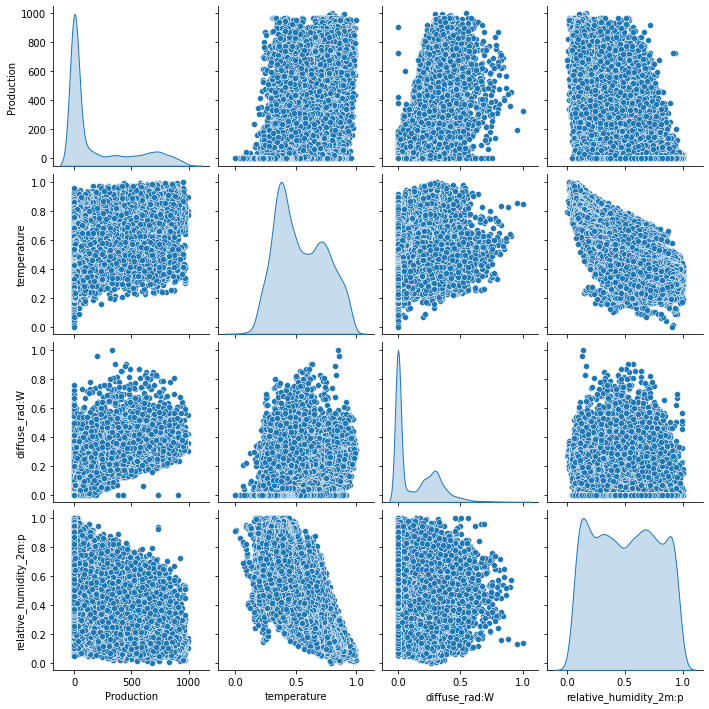

In [9]:
sns.pairplot(normalized[['Production', 'temperature', 'diffuse_rad:W', 'relative_humidity_2m:p']], diag_kind='kde')

In [11]:
train_dataset = normalized.sample(frac=0.8, random_state=0)
test_dataset = normalized.drop(train_dataset.index)

In [12]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Production')
test_labels = test_features.pop('Production')

In [15]:
train_labels


4802     645.0
9516     116.0
10694    269.0
11456      0.0
10085    634.0
         ...  
2045      83.0
3565       0.0
10565      0.0
14639    838.0
9307       0.0
Name: Production, Length: 15229, dtype: float64

In [27]:
from matplotlib import units


horsepower_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=128,activation="relu"),
    tf.keras.layers.Dense(units=1,activation="relu")
])

horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    loss='mean_absolute_error')

In [ ]:
history = horsepower_model.fit(
    train_features,
    train_labels,
    epochs=100,
 
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)


In [ ]:
print("Fit model on training data")
history = horsepower_model.fit(
    train_features,
    train_labels,
    batch_size=64,
    epochs=20,)